# PROJECT FAME

**Problem**: Forecasting from early time well production leads to non-unique estimates of ultimate reserves. The production history required to qualify a forecast as confident is loosely defined.

**Hypthesis**: An accuracy score be used to relate the volume of production history to forecast confidence under different sets of conditions.

# WORK PLAN

1. Create synthetic forecasts
    - Exponential decline
    - Arps b=0.5, b~1.0, b=1.5
    - Irregular production case

2. Test different volume sampling periods
    - Daily data
    - Monthly data

3. Add error to the forecast
    - Zero error
    - Low error (how TBD)
    - Medium error
    - High error

4. At different time horizons ...
    - Bootstrap 100 realizations of the prior production history
        - *complication*: production history broadly declines as the result of withdraw, the window size for each boostrapped sample will need to be small or some bias needs to be introduced on the boostrap.
    - For each boostrap, regress an ARPs decline and calculate EUR from the
       forecast.
    - Caclulate accuracy score

5. Summarize findings.

Notes:
- From examples of real production data, production noise can be modeled with a
    - Laplace Distribition
    - Mean ~ 0
    - STD [10-40]

# EXAMPLE OF ONE ITERATION

In [39]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import pickle
from scipy.optimize import minimize
from scipy.stats import gennorm
from matplotlib.ticker import StrMethodFormatter
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

golden_ratio = (1 + np.sqrt(5)) / 2

In [40]:
class ground_truth:
    """
    Class to generate ground truth data for a given set of parameters.

    Parameters:
    qi: Initial production rate, bopd
    di: Initial decline rate, effective annual
    b: Decline exponent
    dmin: Minimum decline rate, effective annual
    qab: Abandonment rate, bopd
    scale: Time scale, 'month' or 'day'
    """
    def __init__(self, qi, di, b, dmin, qab, time_scale):
        self.qi = qi
        self.di = di
        self.b = b
        self.dmin = dmin
        self.qab = qab
        self.time_scale = time_scale
        self.time_scalar = 365 if time_scale == 'day' else 12
        self.t = np.arange(0, 100 * self.time_scalar, 1)
        self.rate = self._calc_modified_arps(qi=self.qi, di=self.di, b=self.b, dmin=self.dmin, qab=self.qab)
        self.cum = np.cumsum(self.rate)
        self.eur = np.max(self.cum)
        self.quantiles = list(range(1, 100, 1))
        self.confidence_intervals = list(range(1, 50, 1))
    
    def _calc_modified_arps(self, qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = self.t
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / self.time_scalar)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / self.time_scalar) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / self.time_scalar) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

    def _calculate_error_array(self, beta, loc, scale):
        """
        Caclulate an arrate with error and return it.
        """
        error = gennorm.rvs(beta=beta, loc=loc, scale=scale, size=len(self.rate))
        clipped_error = np.where((error < -1) | (error > 1), 0, error)
        return self.rate * (1 + clipped_error)

    def add_error(self, beta, loc, scale):
        """
        Add normally distributed error to the production rate.
        
        Parameters:
        - beta: Shape parameter for the generalized normal distribution
        - loc: Location parameter for the generalized normal distribution
        - scale: Scale parameter for the generalized normal distribution

        Returns:
        - rate_error: Production rate with error
        """
        self.rate_error = self._calculate_error_array(beta=beta, loc=loc, scale=scale)
        self.rate_error = np.where(self.rate_error < 0, self.rate, self.rate_error)
        self.rate_error_moving_avg = (pd.Series(self.rate_error).rolling(window=30, min_periods=1, center=True)
                                                                .mean()
                                                                .values)
        self.cum_error = np.cumsum(self.rate_error)
        self.eur_error = np.max(self.cum_error)

    def monte_carlo(self, iterations, beta, loc, scale):
        """
        Simulate multiple realizatsion for the production rate with error.
        
        Parameters:
        - iterations: Number of bootstrap iterations to perform
        - beta: Shape parameter for the generalized normal distribution
        - loc: Location parameter for the generalized normal distribution
        - scale: Scale parameter for the generalized normal distribution

        Returns:
        - monte_carlo_array: Array of bootstrapped production rates
                        [iterations, len(self.rate)]
        """
        monte_carlo_array = np.zeros(shape=(iterations, len(self.rate_error)))
        for i in range(iterations):
            monte_carlo_array[i, :] = self._calculate_error_array(beta=beta, loc=loc, scale=scale)
        self.monte_carlo_array = monte_carlo_array

    def bootstrap(self, iterations):
        """
        Simulate multiple realizatsion for the production rate with error.
        
        Parameters:
        - iterations: Number of bootstrap iterations to perform

        Returns:
        - monte_carlo_array: Array of bootstrapped production rates
                        [iterations, len(self.rate)]
        """
        mask = self.rate_error > 0
        bootstrap_array = np.zeros(shape=(iterations, len(self.rate_error[mask])))
        for i in range(iterations):
            bootstrap_array[i, :] = np.random.choice(self.rate_error[mask], 
                                                     len(self.rate_error[mask]), 
                                                     replace=True)
        self.bootstrap_array = bootstrap_array
    
    def windowed_bootstrap(self, iterations, window_size):
        """
        Simulate multiple realizatsion for the production rate with error.
        
        Parameters:
        - iterations: Number of bootstrap iterations to perform
        - window_size: Size of the expanding window

        Returns:
        - monte_carlo_array: Array of bootstrapped production rates
                        [iterations, len(self.rate)]
        """
        bootstrap_array = np.zeros(shape=(iterations, len(self.rate_error)))
        for i in range(iterations):
            bootstrap_array[i, :] = (pd.Series(self.rate_error)
                                       .rolling(window=window_size,
                                                min_periods=1,
                                                center=True)
                                       .apply(lambda x: np.random.choice(x, 1, replace=True))
                                       .values)                  
        self.bootstrap_array = bootstrap_array

    def _regress_forecast(self, params, history):
        """
        Calculate forecasts and return MSE for the minimizer.
        
        Paramters:
        - params: List of parameters to optimize

        Returns:
        - mse: Mean squared error between the forecast and the history
        """
        di, b = params
        forecast = self._calc_modified_arps(qi=self.qi, di=di, b=b, dmin=self.dmin, qab=self.qab)
        mse = np.sum((forecast[:len(history)] - history) ** 2)
        return mse

    
    def calc_forecasts(self, time_increments, max_windows, initial, bounds, which):
        """
        Calculate forecasts for each monte carlo iteration using an expanding
        window the size of the time increments.

        Parameters:
        - time_increments: Size of the expanding window
        - max_windows: Maximum number of expanding windows to calculate
        - initial: Initial guess for the minimizer [di, b]
        - bounds: [(di_min, di_max), (b_min, b_max))]
        - which: 'monte_carlo' or 'bootstrap' or 'moving_average'

        Returns: Array of EURs for each monte carlo iteration and window_size.
                    [monte_carlo_iterations, time_increments]
        """
        
        if which == 'monte_carlo':
            data = self.monte_carlo_array
        elif which == 'bootstrap':
            data = self.bootstrap_array
        elif which == 'moving_average':
            data = self.rate_error_moving_avg.reshape(1, -1)
        else:
            raise ValueError('which must be "monte_carlo" or "bootstrap" or "moving_average"')
        
        expanding_windows = np.arange(time_increments, (time_increments + 1) * max_windows, time_increments)
        iterations = data.shape[0]
        fcst_eur_array = np.zeros(shape=(iterations, len(expanding_windows)))
        for i in range(iterations):
            for j, w in enumerate(expanding_windows):
                history = data[i, :w]
                match_di, match_b = minimize(self._regress_forecast, 
                                             x0=initial, 
                                             args=(history), 
                                             bounds=bounds).x
                forecast = self._calc_modified_arps(qi=self.qi, di=match_di, b=match_b, dmin=self.dmin, qab=self.qab)
                eur = np.max(np.cumsum(forecast))
                fcst_eur_array[i, j] = eur
        if which == 'moving_average':
            self.moving_average_fcst_eur = fcst_eur_array[0, :]
        else:
            self.fcst_eur_array = fcst_eur_array 


    def average_forecast_error_quantiles(self):
        """
        Calculate the forecast error for each bootstap and gather the 
        quantiles.

        Returns: Array of average percentage error at each quantile for 
                    each bootstrap iteration. 
                    [quantiles, time_increments]
                 
        """
        quantiles = self.quantiles
        pct_error_array = (self.fcst_eur_array - self.eur_error) / self.eur_error * 100
        quantile_array = np.percentile(pct_error_array, quantiles, axis=0)
        self.avg_fcst_error_quantiles = quantile_array

    def score_prediction(self):
        """
        Calculate whether or not the actual EUR is within a range of confidence 
        intervals.

        Returns: Array of 1s and 0s for each confidence interval and bootstrap 
                    iteration. [confidence_intervals, time_increments]
                 
        """
        confidence_intervals = self.confidence_intervals
        score_array = np.zeros([len(confidence_intervals), self.fcst_eur_array.shape[1]])
        for i, interval in enumerate(confidence_intervals):
            for j in range(self.fcst_eur_array.shape[1]):
                lower = np.percentile(self.fcst_eur_array[:, j], 50 - interval)
                upper = np.percentile(self.fcst_eur_array[:, j], 50 + interval)
                if self.eur_error > lower and self.eur_error < upper:
                    score_array[i, j] = 1
                else:    
                    score_array[i, j] = 0
        self.score_array = score_array




In [41]:
# create a test instance of the well object and add error to the production rate
test = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
beta = 0.5
loc = 0
scale = 0.05 
test.add_error(beta=beta, loc=loc, scale=scale)

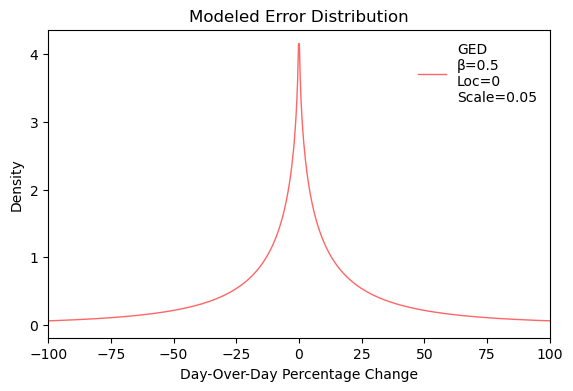

In [42]:
fig, ax = plt.subplots(figsize=(golden_ratio * 4, 4))
x = np.linspace(gennorm.ppf(0.01, beta, loc, scale), gennorm.ppf(0.99, beta, loc, scale), 1000)
ax.plot(x * 100, gennorm.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, 
        label=f'GED\n\u03B2={beta}\nLoc={loc}\nScale={scale}')
ax.set(title='Modeled Error Distribution', xlabel='Day-Over-Day Percentage Change', ylabel='Density', xlim=(-100,100))
ax.legend(loc='best', frameon=False)
plt.show()

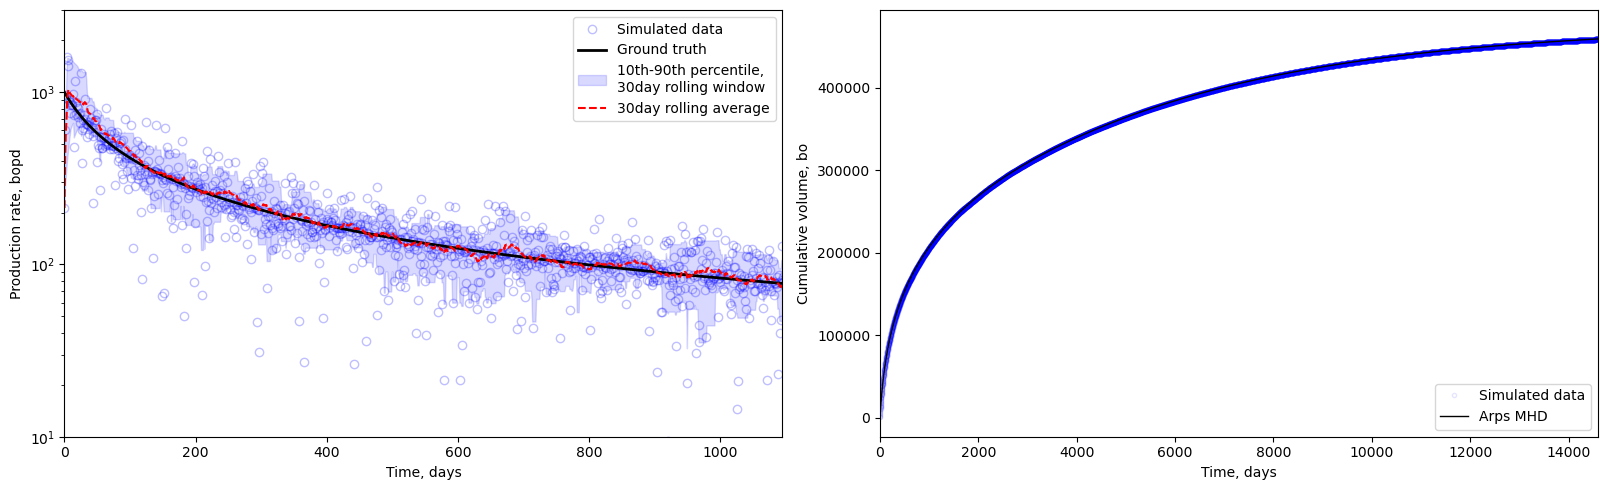

In [43]:
# plot the production rate and cumulative production with error for the test instance
moving_p10 = pd.Series(test.rate_error).rolling(window=30, min_periods=1).quantile(0.10)
moving_p90 = pd.Series(test.rate_error).rolling(window=30, min_periods=1).quantile(0.90)
moving_avg = pd.Series(test.rate_error).rolling(window=30, min_periods=1).mean()

fig, axs = plt.subplots(ncols=2, figsize=(golden_ratio * 5 * 2, 5))
axs[0].plot(test.t, test.rate_error, 'o', c='none', mec='b', alpha=0.25, label='Simulated data')
axs[0].plot(test.t, test.rate, 'k-', label='Ground truth', lw=2)
axs[0].fill_between(test.t, moving_p10, moving_p90, color='b', alpha=0.15, 
                    label='10th-90th percentile,\n30day rolling window')
axs[0].plot(test.t, moving_avg, 'r--', label='30day rolling average')
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', xlim=(0,365 * 3), ylim=(10, 3000), yscale='log')
axs[0].legend(loc='upper right')
axs[1].plot(test.t, test.cum_error, '.', c='none', mec='b', alpha=0.10, label='Simulated data')
axs[1].plot(test.t, test.cum, 'k-', label='Arps MHD', lw=1)
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,365*40))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()

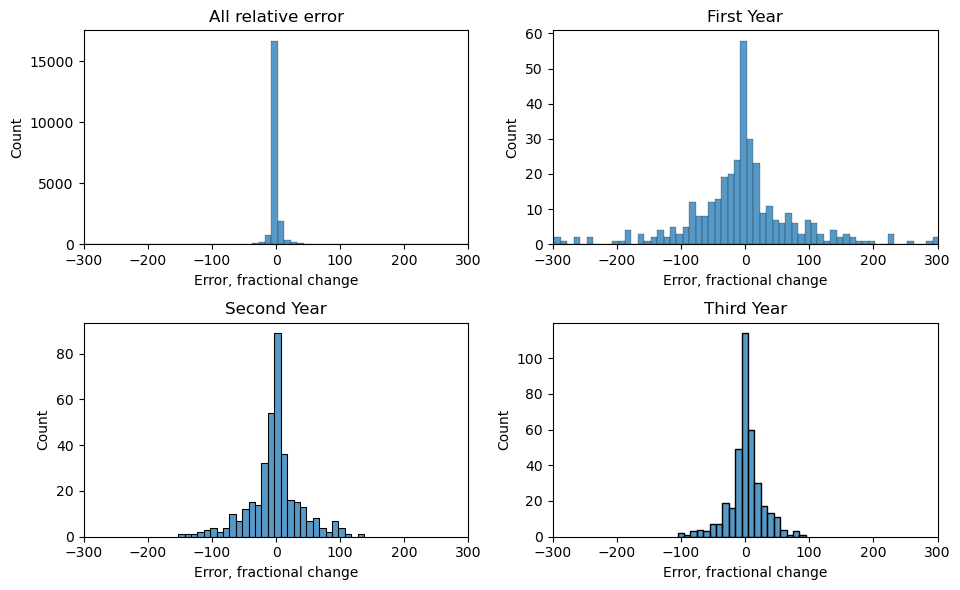

In [44]:

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(golden_ratio * 3 * 2, 3 * 2))
mask = test.rate > 0
sns.histplot((test.rate_error[mask] - test.rate[mask]), ax=axs[0,0], binwidth=10)
axs[0,0].set(title='All relative error', xlabel='Error, fractional change', ylabel='Count', xlim=(-300, 300))
sns.histplot((test.rate_error[mask][:365] - test.rate[mask][:365]), ax=axs[0,1], binwidth=10)
axs[0,1].set(title='First Year', xlabel='Error, fractional change', ylabel='Count', xlim=(-300, 300))
sns.histplot((test.rate_error[mask][365:730] - test.rate[mask][365:730]), ax=axs[1,0], binwidth=10)
axs[1,0].set(title='Second Year', xlabel='Error, fractional change', ylabel='Count', xlim=(-300, 300))
sns.histplot((test.rate_error[mask][730:1095] - test.rate[mask][730:1095]), ax=axs[1,1], binwidth=10)
axs[1,1].set(title='Third Year', xlabel='Error, fractional change', ylabel='Count', xlim=(-300, 300))
plt.tight_layout(); plt.show()

In [45]:
# create the bootstrap array for the test instance
test.monte_carlo(
    iterations=100, 
    beta=0.5, 
    loc=0, 
    scale=0.05
    )

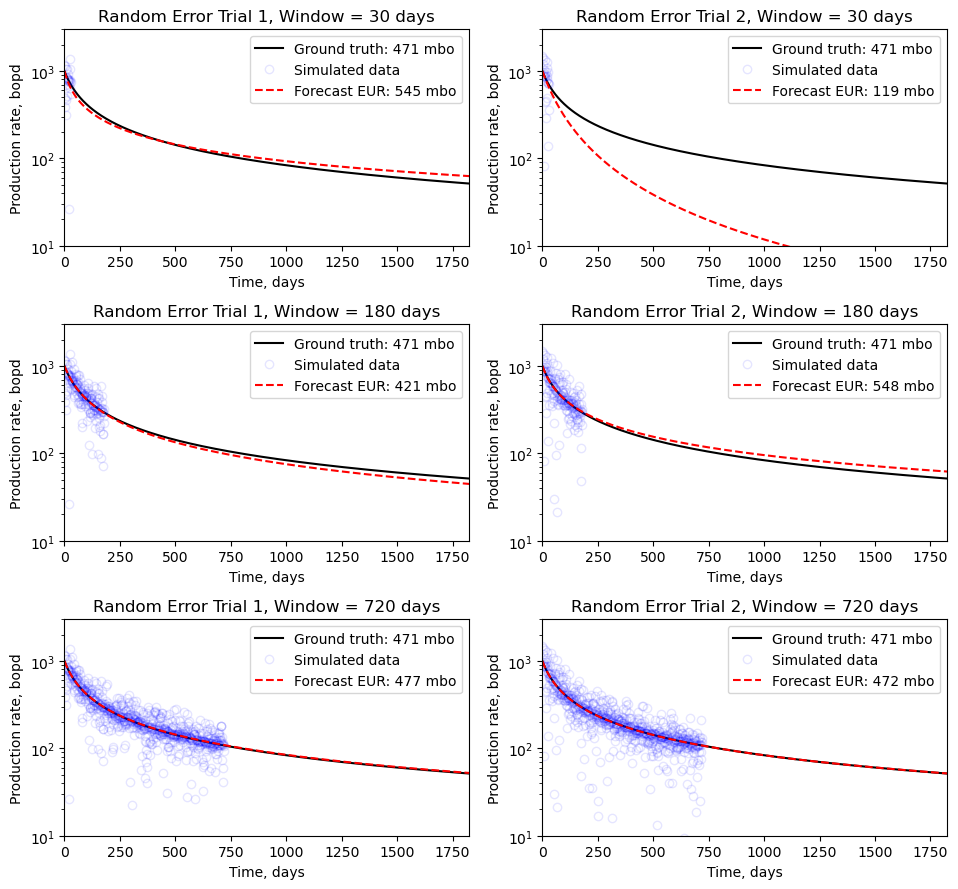

In [46]:
# create some forecast visuals
def calculate_single_monte_carlo_fit(boot_strap_iteration, window_max, initial, bounds, which):
    history = test.monte_carlo_array[boot_strap_iteration, :window_max]
    match_di, match_b = minimize(test._regress_forecast, 
                                    x0=initial, 
                                    args=(history), 
                                    bounds=bounds).x
    forecast = test._calc_modified_arps(qi=test.qi, di=match_di, b=match_b, dmin=test.dmin, qab=test.qab)
    return forecast, match_di, match_b

boot_strap_iteration = [5,10]
bounds = [(0.5, 0.99), (0.5, 1.5)]
initial_guess = [0.75, 1.001]
which = 'monte_carlo'

# plot the examples
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * golden_ratio * 3, 3 * 3))
for i, bs in enumerate(boot_strap_iteration):
    window_1 = 30
    forecast_1, match_di_1, match_b_1 = calculate_single_monte_carlo_fit(bs, window_1, initial_guess, bounds, which)
    axs[0, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[0, i].plot(range(0,window_1), test.monte_carlo_array[bs, :window_1], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[0, i].plot(test.t, forecast_1, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_1))/1000:.0f} mbo')
    axs[0, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Random Error Trial {i+1}, Window = {window_1} days')
    axs[0, i].legend(loc='upper right')

    window_2 = 180
    forecast_2, match_di_2, match_b_2 = calculate_single_monte_carlo_fit(bs, window_2, initial_guess, bounds, which)
    axs[1, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[1, i].plot(range(0,window_2), test.monte_carlo_array[bs, :window_2], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[1, i].plot(test.t, forecast_2, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_2))/1000:.0f} mbo')
    axs[1, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Random Error Trial {i+1}, Window = {window_2} days')
    axs[1, i].legend(loc='upper right')

    window_3 = 720
    forecast_3, match_di_3, match_b_3 = calculate_single_monte_carlo_fit(bs, window_3, initial_guess, bounds, which)
    axs[2, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[2, i].plot(range(0,window_3), test.monte_carlo_array[bs, :window_3], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[2, i].plot(test.t, forecast_3, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_3))/1000:.0f} mbo')
    axs[2, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Random Error Trial {i+1}, Window = {window_3} days')
    axs[2, i].legend(loc='upper right')

plt.tight_layout(); plt.show() 

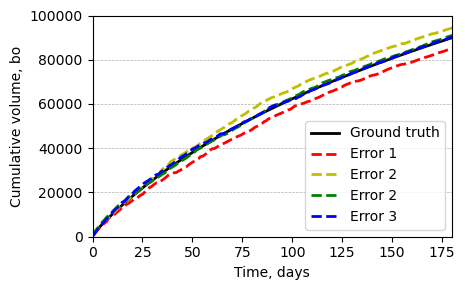

In [90]:
# compare cum-time for a couple different error instances
gt = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
error1 = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
error2 = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
error3 = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
error4 = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
error1.add_error(beta=0.5, loc=0, scale=0.05)  # beta=0.5, loc=0, scale=0.05
error2.add_error(beta=0.5, loc=0, scale=0.05)  # beta=0.5, loc=0, scale=0.05
error3.add_error(beta=0.5, loc=0, scale=0.05)  # beta=0.5, loc=0, scale=0.05
error4.add_error(beta=0.5, loc=0, scale=0.05)  # beta=0.5, loc=0, scale=0.05

fig, ax = plt.subplots(figsize=(golden_ratio * 3, 3))
ax.plot(gt.t, gt.cum, 'k-', label='Ground truth', lw=2)
ax.plot(error1.t, error1.cum_error, 'r--', label='Error 1', lw=2)
ax.plot(error2.t, error2.cum_error, 'y--', label='Error 2', lw=2)
ax.plot(error3.t, error3.cum_error, 'g--', label='Error 2', lw=2)
ax.plot(error4.t, error4.cum_error, 'b--', label='Error 3', lw=2)
ax.set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,180), ylim=(0, 1.0e5))
ax.legend(loc='lower right')
ax.grid(True, which='both', axis='y', linestyle='--', lw=0.5)
plt.tight_layout(); plt.show()


In [56]:
# calculate forecasts for bootstrap iterations and different expanding windows
test.calc_forecasts(time_increments=60,
                    max_windows=24,
                    initial=[0.75, 1.0001],
                    bounds=[(0.5, 0.99), (0.5, 1.5)],
                    which='monte_carlo')

In [57]:
# calculate a forecasts for each window using a moving average
test.calc_forecasts(time_increments=60,
                    max_windows=22,
                    initial=[0.75, 1.0001],
                    bounds=[(0.5, 0.99), (0.5, 1.5)],
                    which='moving_average')

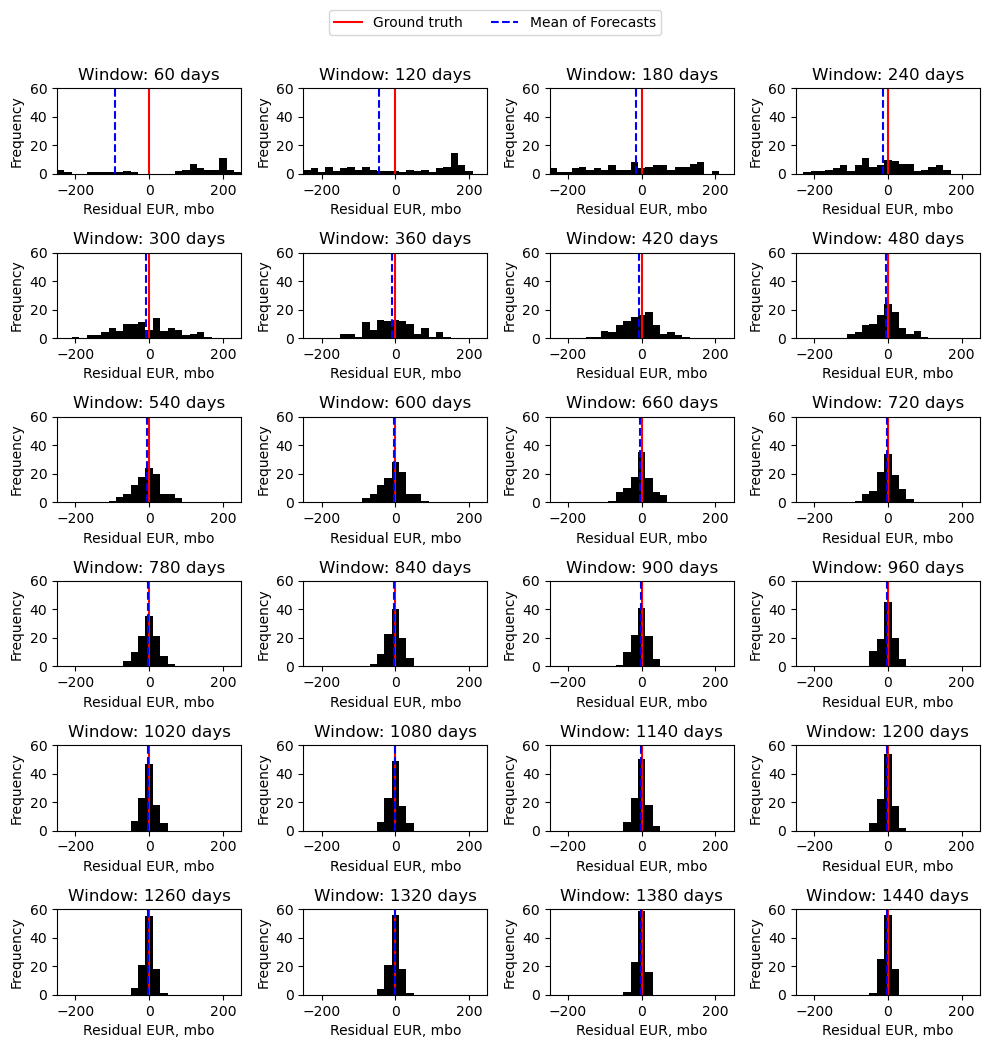

In [58]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(10, 10))
bin_width = 20
bin_edges = np.arange(-250, 250 + bin_width, bin_width)
for i in range(0, test.fcst_eur_array.shape[1]):
    ax[i // 4, i % 4].hist(test.fcst_eur_array[:, i]/1000 - test.eur_error/1000, bins=bin_edges, color='k')
    ax[i // 4, i % 4].axvline(0, c='r', label='Ground truth')
    ax[i // 4, i % 4].axvline(np.mean(test.fcst_eur_array[:,i] - test.eur_error)/1000, c='b', ls='--', label='Mean of Forecasts')
    # ax[i // 4, i % 4].axvline(test.moving_average_fcst_eur[i]/1000, c='g', ls='--', label='Moving average forecast')
    ax[i // 4, i % 4].set(xlim=(-250,250), ylim=(0,60), title=f'Window: {i * 60 + 60} days', xlabel='Residual EUR, mbo', ylabel='Frequency')
    plt.tight_layout()

# Add legend at the top of the figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout(); plt.show()


In [59]:
test_bootstrap = test
test_bootstrap.bootstrap(100)
test_bootstrap.calc_forecasts(time_increments=60,
                              max_windows=22,
                              initial=[0.75, 1.0001],
                              bounds=[(0.5, 0.99), (0.5, 1.5)],
                              which='bootstrap')

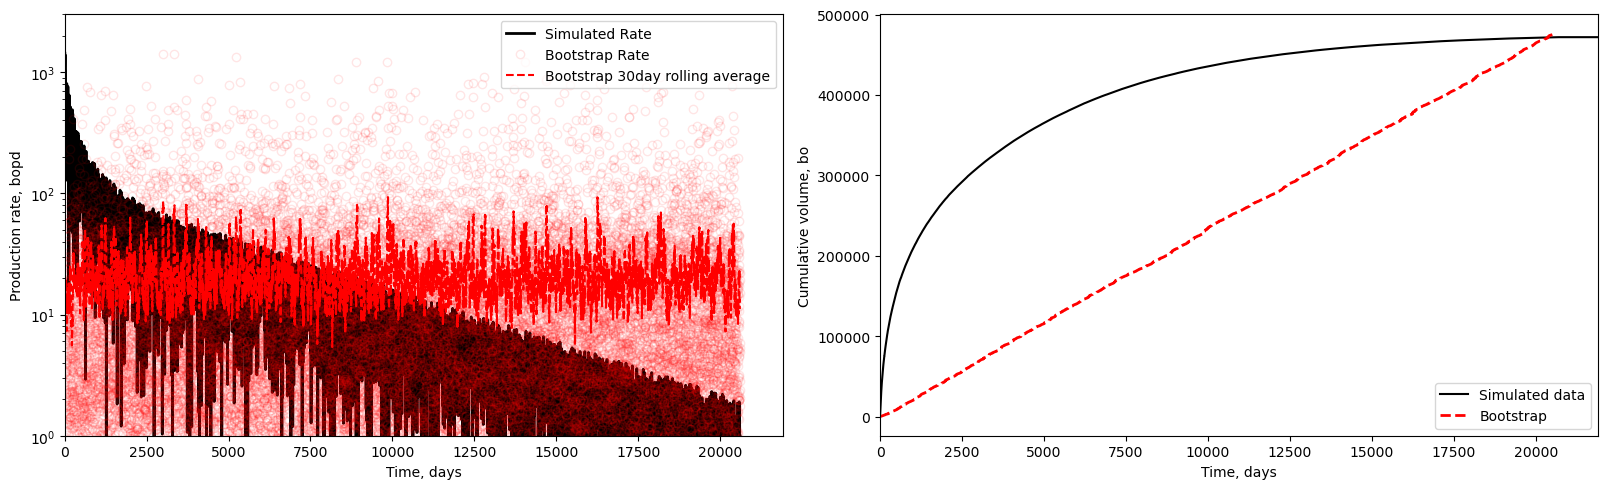

In [60]:
# plot the production rate and cumulative production with error for a bootstrap
bootstrap_index = np.random.randint(0, test_bootstrap.bootstrap_array.shape[0])
bootstrap_rate = test_bootstrap.bootstrap_array[bootstrap_index, :]
bootstrap_cum = np.cumsum(bootstrap_rate)   

moving_p10 = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).quantile(0.10)
moving_p90 = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).quantile(0.90)
moving_avg = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).mean()

fig, axs = plt.subplots(ncols=2, figsize=(golden_ratio * 5 * 2, 5))
axs[0].plot(test.t, test.rate_error, 'k-', label='Simulated Rate', lw=2)
axs[0].plot(test.t[:len(bootstrap_rate)], bootstrap_rate, 'o', c='none', mec='r', alpha=0.10, label='Bootstrap Rate')
# axs[0].fill_between(test.t[:len(bootstrap_rate)], moving_p10, moving_p90, color='r', alpha=0.25, 
#                     label='10th-90th percentile,\n30day rolling window')
axs[0].plot(test.t[:len(bootstrap_rate)], moving_avg, 'r--', label='Bootstrap 30day rolling average')
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 60), ylim=(1, 3000))
axs[0].legend(loc='upper right')
axs[1].plot(test.t, test.cum_error, 'k-', label='Simulated data')
axs[1].plot(test.t[:len(bootstrap_cum)], bootstrap_cum, 'r--', label='Bootstrap', lw=2)
# axs[1].plot(test.t, test.cum, 'k-', label='Simulated data', lw=2)
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,365*60))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()

In [61]:
test_windowed_bootstrap = test
test_windowed_bootstrap.windowed_bootstrap(100, window_size=30)
test_windowed_bootstrap.calc_forecasts(time_increments=60,
                                       max_windows=22,
                                       initial=[0.75, 1.0001],
                                       bounds=[(0.5, 0.99), (0.5, 1.5)],
                                       which='bootstrap')

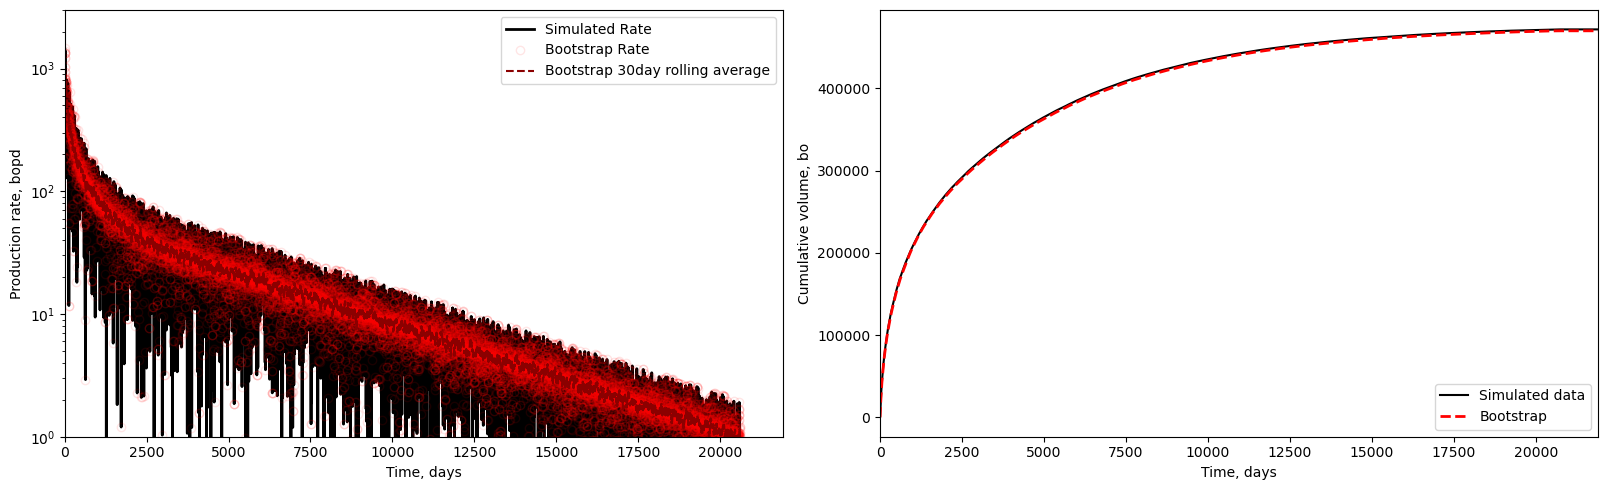

In [62]:
# plot the production rate and cumulative production with error for a bootstrap
bootstrap_index = np.random.randint(0, test_windowed_bootstrap.bootstrap_array.shape[0])
bootstrap_rate = test_windowed_bootstrap.bootstrap_array[bootstrap_index, :]
bootstrap_cum = np.cumsum(bootstrap_rate)   

moving_p10 = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).quantile(0.10)
moving_p90 = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).quantile(0.90)
moving_avg = pd.Series(bootstrap_rate).rolling(window=30, min_periods=1).mean()

fig, axs = plt.subplots(ncols=2, figsize=(golden_ratio * 5 * 2, 5))
axs[0].plot(test.t, test.rate_error, 'k-', label='Simulated Rate', lw=2)
axs[0].plot(test.t[:len(bootstrap_rate)], bootstrap_rate, 'o', c='none', mec='r', alpha=0.10, label='Bootstrap Rate')
# axs[0].fill_between(test.t[:len(bootstrap_rate)], moving_p10, moving_p90, color='r', alpha=0.25, 
#                     label='10th-90th percentile,\n30day rolling window')
axs[0].plot(test.t[:len(bootstrap_rate)], moving_avg, '--', c='darkred', label='Bootstrap 30day rolling average')
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 60), ylim=(1, 3000))
axs[0].legend(loc='upper right')
axs[1].plot(test.t, test.cum_error, 'k-', label='Simulated data')
axs[1].plot(test.t[:len(bootstrap_cum)], bootstrap_cum, 'r--', label='Bootstrap', lw=2)
# axs[1].plot(test.t, test.cum, 'k-', label='Simulated data', lw=2)
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,365*60))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()

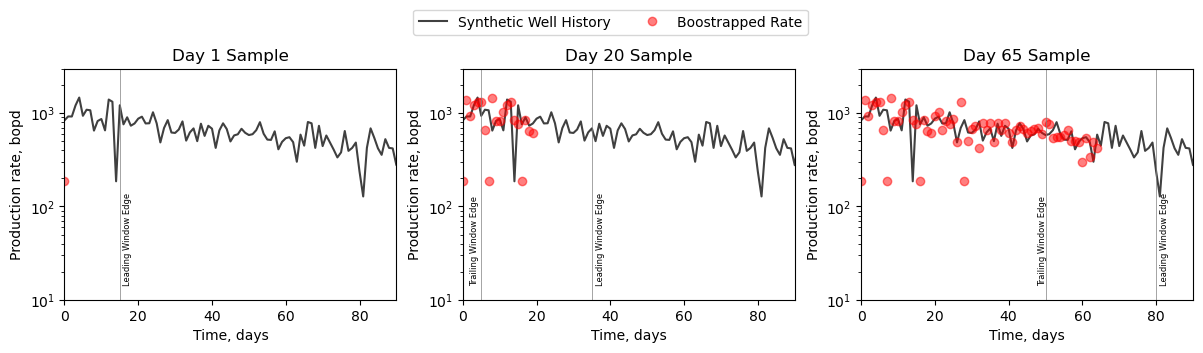

In [63]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(golden_ratio * 3 * 3, 3))

axs[0].plot(test.t, test.rate_error, '-', c='k', alpha=0.75, label='Synthetic Well History')
axs[0].plot(test.t[:1], bootstrap_rate[:1], 'o', c='r', alpha=0.5, label='Boostrapped Rate')
axs[0].axvline(0, c='gray', lw=0.5)
axs[0].axvline(15, c='gray', lw=0.5)
axs[0].text(16, 15, 'Leading Window Edge', rotation='vertical', size=6)
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', xlim=(0,90), ylim=(10, 3000), yscale='log',
           title='Day 1 Sample')

axs[1].plot(test.t, test.rate_error, '-', c='k', alpha=0.75, label='Synthetic Well History')
axs[1].plot(test.t[:20], bootstrap_rate[:20], 'o', c='r', alpha=0.5, label='Boostrapped Rate')
axs[1].axvline(5, c='gray', lw=0.5)
axs[1].axvline(35, c='gray', lw=0.5)
axs[1].text(2, 15, 'Trailing Window Edge', rotation='vertical', size=6)
axs[1].text(36, 15, 'Leading Window Edge', rotation='vertical', size=6)
axs[1].set(xlabel='Time, days', ylabel='Production rate, bopd', xlim=(0,90), ylim=(10, 3000), yscale='log',
           title='Day 20 Sample')

axs[2].plot(test.t, test.rate_error, '-', c='k', alpha=0.75, label='Synthetic Well History')
axs[2].plot(test.t[:65], bootstrap_rate[:65], 'o', c='r', alpha=0.5, label='Boostrapped Rate')
axs[2].axvline(50, c='gray', lw=0.5)
axs[2].axvline(80, c='gray', lw=0.5)
axs[2].text(48, 15, 'Trailing Window Edge', rotation='vertical', size=6)
axs[2].text(81, 15, 'Leading Window Edge', rotation='vertical', size=6)
axs[2].set(xlabel='Time, days', ylabel='Production rate, bopd', xlim=(0,90), ylim=(10, 3000), yscale='log',
           title='Day 65 Sample')

# Add legend at the top of the figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=2)

plt.show()

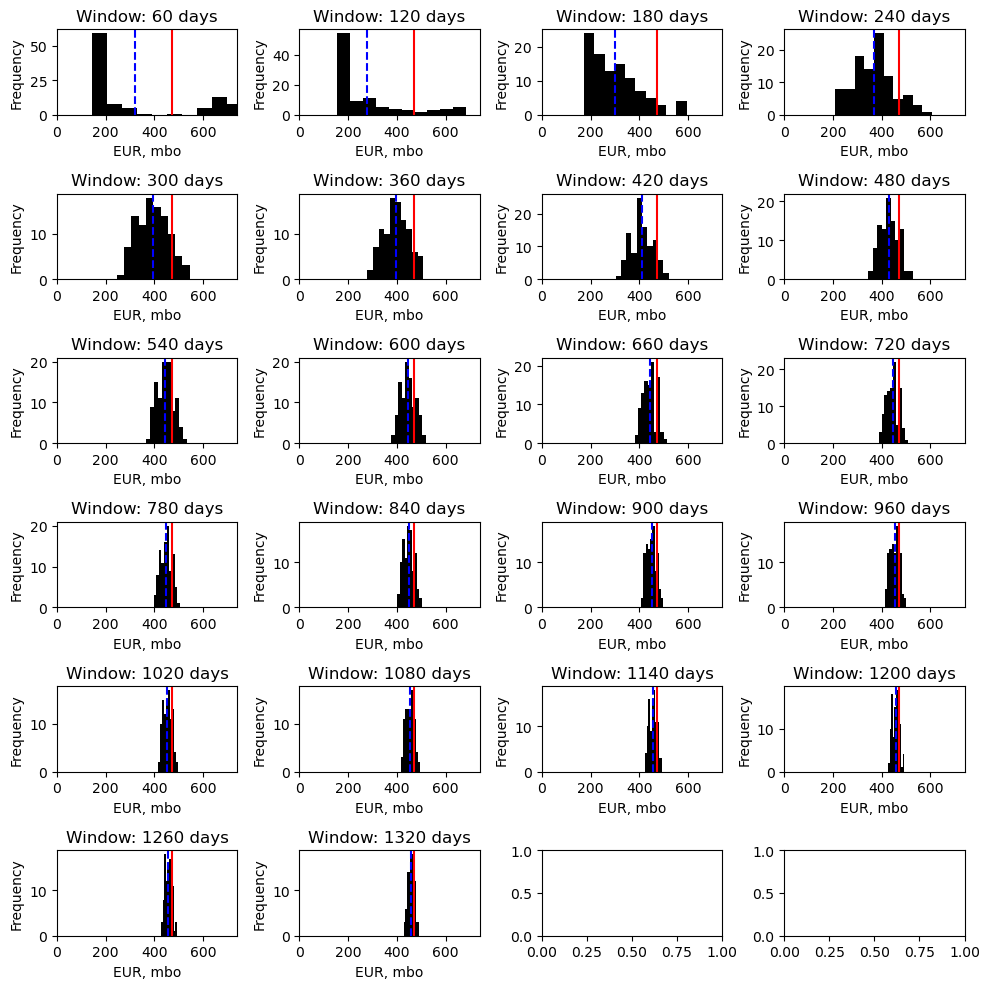

In [64]:
# create histrograms of bootstrapped forecasts for each time window of the test instance
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(10, 10))
for i in range(0, test_windowed_bootstrap.fcst_eur_array.shape[1]):
    axs[i // 4, i % 4].hist(test_windowed_bootstrap.fcst_eur_array[:,i]/1000, color='k')
    axs[i // 4, i % 4].axvline(test_windowed_bootstrap.eur/1000, c='r', label='Ground truth')
    axs[i // 4, i % 4].axvline(np.mean(test_windowed_bootstrap.fcst_eur_array[:,i])/1000, c='b', ls='--', label='Mean forecast')
    axs[i // 4, i % 4].set(xlim=(0,740), title=f'Window: {i * 60 + 60} days', xlabel='EUR, mbo', ylabel='Frequency')

    plt.tight_layout()
plt.tight_layout(); plt.show()

# Repeat the process across multiple well forecasts

In [65]:
# repeat the process for a range of different well forecasts

forecast_parameters = pd.read_excel('Forecast_Input_Parameters.xlsx')
forecast_parameters['eur'] = None
forecast_parameters['well_objects'] = None
forecast_parameters['score'] = None

beta = 0.5
loc = 0
scale = 0.05 
monte_carlo_iterations = 100
time_increment = 90
max_windows = 8
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

quantile_array = list()
score_array = list()
for i, row in tqdm(forecast_parameters.iterrows(), total=len(forecast_parameters)):
    well = ground_truth(row['qi'], row['di'], row['b'], dmin, qab, 'day')
    well.add_error(beta=beta, loc=loc, scale=scale)
    well.monte_carlo(iterations=monte_carlo_iterations, beta=beta, loc=loc, scale=scale)
    well.calc_forecasts(time_increments=time_increment, max_windows=max_windows, 
                        initial=initial_guess, bounds=bounds, which='monte_carlo')
    well.average_forecast_error_quantiles()
    well.score_prediction()
    forecast_parameters.loc[i, 'eur'] = well.eur
    forecast_parameters.loc[i, 'well_objects'] = well
    quantile_array.append(well.avg_fcst_error_quantiles)
    score_array.append(well.score_array)

quantile_array = np.stack(quantile_array) # [well_objects, confidence_intervals, time_increments]
score_array = np.stack(score_array) # [well_objects, confidence_intervals, time_increments]

  0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
# average the quantiles across the well objects for each time increment
# [confidence_intervals, time_increments]
avg_quantiles = np.mean(quantile_array, axis=0)

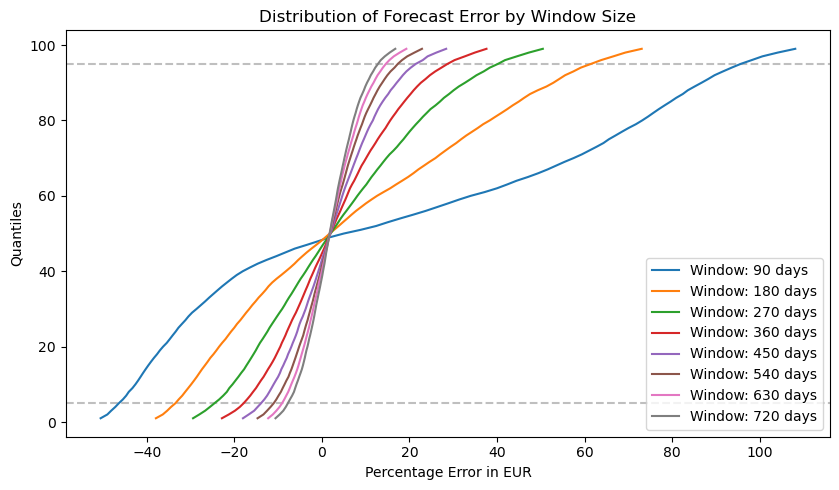

In [67]:
quantiles = forecast_parameters.iloc[0]['well_objects'].quantiles
xlim=(-50, 120)

fig, ax = plt.subplots(figsize=((xlim[1] - xlim[0]) / 100 * 5, 5))
ax.axhline(95, c='gray', ls='--', alpha=0.5)
ax.axhline(5, c='gray', ls='--', alpha=0.5)
for i in range(0, avg_quantiles.shape[1]):
    ax.plot(avg_quantiles[:, i], quantiles, 
            label=f'Window: {(i + 1) * time_increment} days')
ax.set(xlabel='Percentage Error in EUR', ylabel='Quantiles', 
       title='Distribution of Forecast Error by Window Size')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()

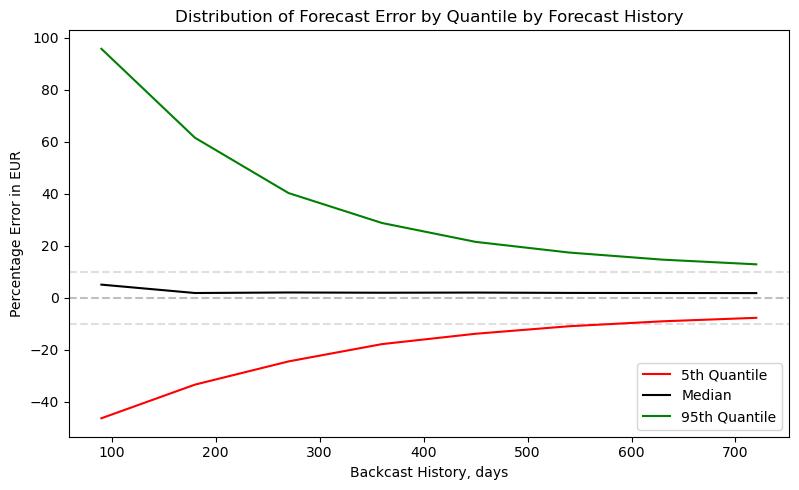

In [68]:
windows = range(time_increment, (time_increment + 1) * max_windows, time_increment)

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(0, c='gray', ls='--', alpha=0.5)
ax.axhline(10, c='gray', ls='--', alpha=0.25)
ax.axhline(-10, c='gray', ls='--', alpha=0.25)
ax.plot(windows, avg_quantiles[4, :], 'r-', label='5th Quantile')
ax.plot(windows, avg_quantiles[49, :], 'k-', label='Median')
ax.plot(windows, avg_quantiles[94, :], 'g-', label='95th Quantile')
ax.set(xlabel='Backcast History, days', ylabel='Percentage Error in EUR', 
       title='Distribution of Forecast Error by Quantile by Forecast History')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()

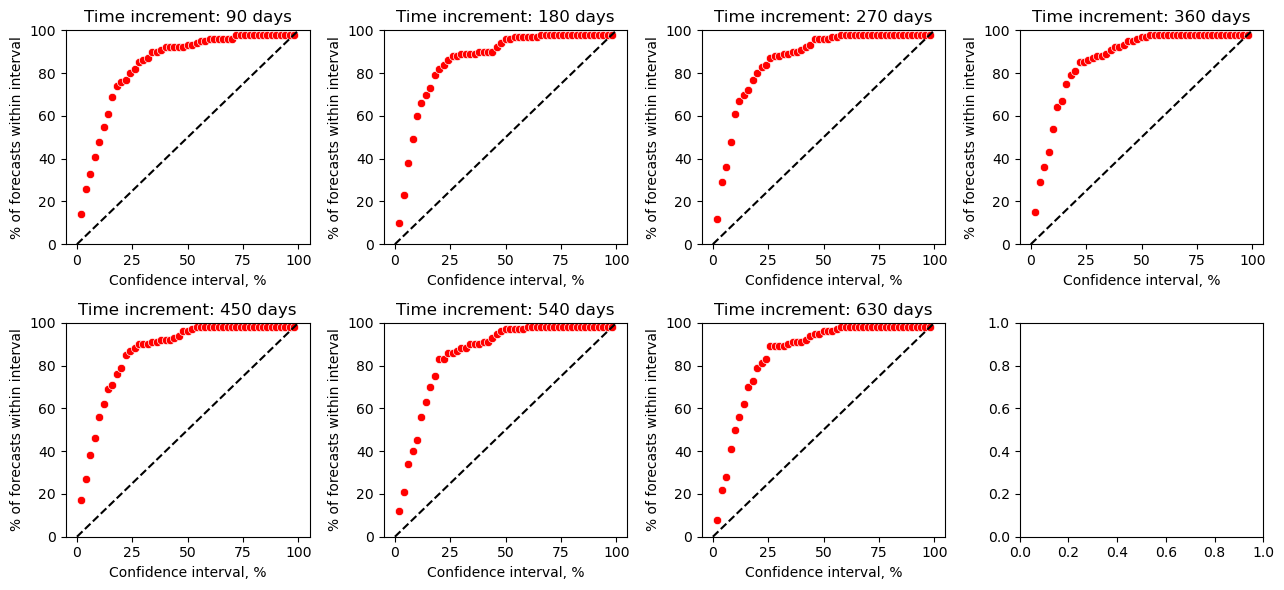

In [69]:
# reshape the score array to [time_increments, confidence_intervals, well_objects]
transposed_score_array = np.transpose(score_array, (2,1,0))

# convert the score arrays to a percentage score fore each confidence interval
# output array is [time_increments, pct_score_by_confidence_interval]
percentage_scores = np.sum(np.transpose(score_array, (2,1,0)), axis=2) / transposed_score_array.shape[2]

# plot summary scores for each time increment
confidence_intervals = forecast_parameters.well_objects.iloc[0].confidence_intervals

fig, axs = plt.subplots(nrows=int((max_windows+1)/4), ncols=4, figsize=(golden_ratio * 2 * 4, 6))

for i in range(0, max_windows-1):
    sns.scatterplot(x=np.array(confidence_intervals) * 2, y=percentage_scores[i, :] * 100, color='r', ax=axs[i//4,i%4])
    axs[i//4, i%4].plot((0,100), (0,100), 'k--')
    axs[i//4, i%4].set(title=f'Time increment: {(i+1) * time_increment} days', xlabel='Confidence interval, %', 
               ylabel='% of forecasts within interval', ylim=(0,100))
    
plt.tight_layout(); plt.show()

# Repeat the same workflow but with bootsraps

In [70]:
# repeat the process for a range of different well forecasts

forecast_parameters = pd.read_excel('Forecast_Input_Parameters.xlsx')
forecast_parameters['eur'] = None
forecast_parameters['well_objects'] = None
forecast_parameters['score'] = None

beta = 0.5
loc = 0
scale = 0.05 
bootstrap_iterations = 100
bootstrap_window = 30
time_increment = 90
max_windows = 9
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

quantile_array_bs = list()
score_array_bs = list()
for i, row in tqdm(forecast_parameters.iterrows(), total=len(forecast_parameters)):
    well = ground_truth(row['qi'], row['di'], row['b'], dmin, qab, 'day')
    well.add_error(beta=beta, loc=loc, scale=scale)
    well.windowed_bootstrap(iterations=bootstrap_iterations, window_size=bootstrap_window)
    well.calc_forecasts(time_increments=time_increment, max_windows=max_windows, 
                        initial=initial_guess, bounds=bounds, which='bootstrap')
    well.average_forecast_error_quantiles()
    well.score_prediction()
    forecast_parameters.loc[i, 'eur'] = well.eur
    forecast_parameters.loc[i, 'well_objects'] = well
    quantile_array_bs.append(well.avg_fcst_error_quantiles)
    score_array_bs.append(well.score_array)

quantile_array_bs = np.stack(quantile_array_bs) # [well_objects, confidence_intervals, time_increments]
score_array_bs = np.stack(score_array_bs) # [well_objects, confidence_intervals, time_increments]

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
# average the quantiles across the well objects for each time increment
# [confidence_intervals, time_increments]
avg_quantiles_bs = np.mean(quantile_array_bs, axis=0)

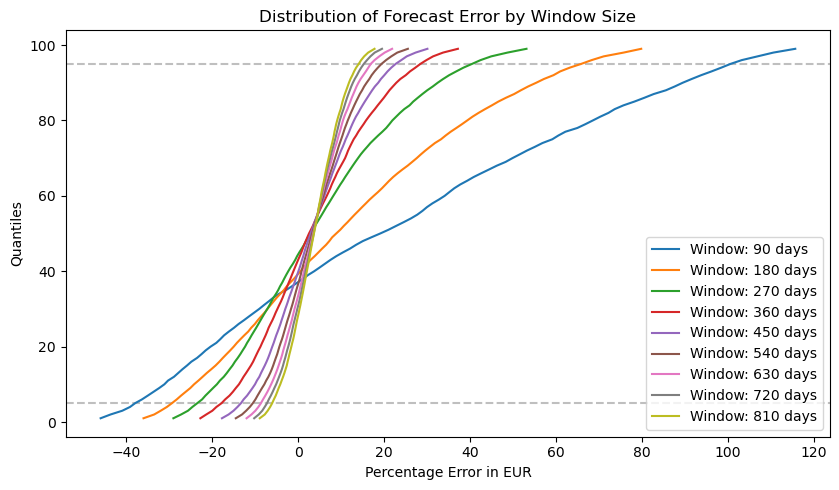

In [72]:
quantiles = forecast_parameters.iloc[0]['well_objects'].quantiles
xlim=(-50, 120)

fig, ax = plt.subplots(figsize=((xlim[1] - xlim[0]) / 100 * 5, 5))
ax.axhline(95, c='gray', ls='--', alpha=0.5)
ax.axhline(5, c='gray', ls='--', alpha=0.5)
for i in range(0, avg_quantiles_bs.shape[1]):
    ax.plot(avg_quantiles_bs[:, i], quantiles, 
            label=f'Window: {(i + 1) * time_increment} days')
ax.set(xlabel='Percentage Error in EUR', ylabel='Quantiles', 
       title='Distribution of Forecast Error by Window Size')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()

In [78]:
[w for w in windows]

[90, 180, 270, 360, 450, 540, 630, 720]

In [87]:
[q for q in avg_quantiles_bs[49, :-1]]

[19.041092488796753,
 8.81459355827707,
 2.78278112965049,
 2.4817802875727075,
 2.863633854695798,
 3.2161468419337433,
 3.4610123529031394,
 3.5812100658373125]

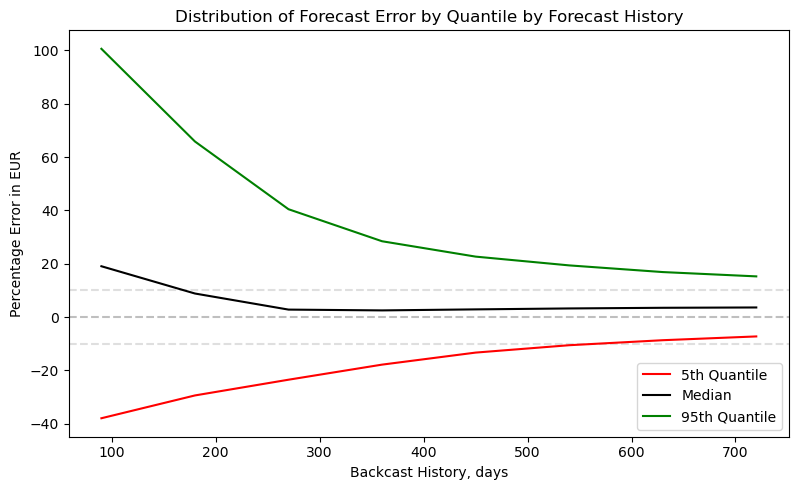

In [82]:
windows = range(time_increment, (time_increment + 1) * max_windows, time_increment)

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(0, c='gray', ls='--', alpha=0.5)
ax.axhline(10, c='gray', ls='--', alpha=0.25)
ax.axhline(-10, c='gray', ls='--', alpha=0.25)
ax.plot(windows, avg_quantiles_bs[4, :-1], 'r-', label='5th Quantile')
ax.plot(windows, avg_quantiles_bs[49, :-1], 'k-', label='Median')
ax.plot(windows, avg_quantiles_bs[94, :-1], 'g-', label='95th Quantile')
ax.set(xlabel='Backcast History, days', ylabel='Percentage Error in EUR', 
       title='Distribution of Forecast Error by Quantile by Forecast History')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()

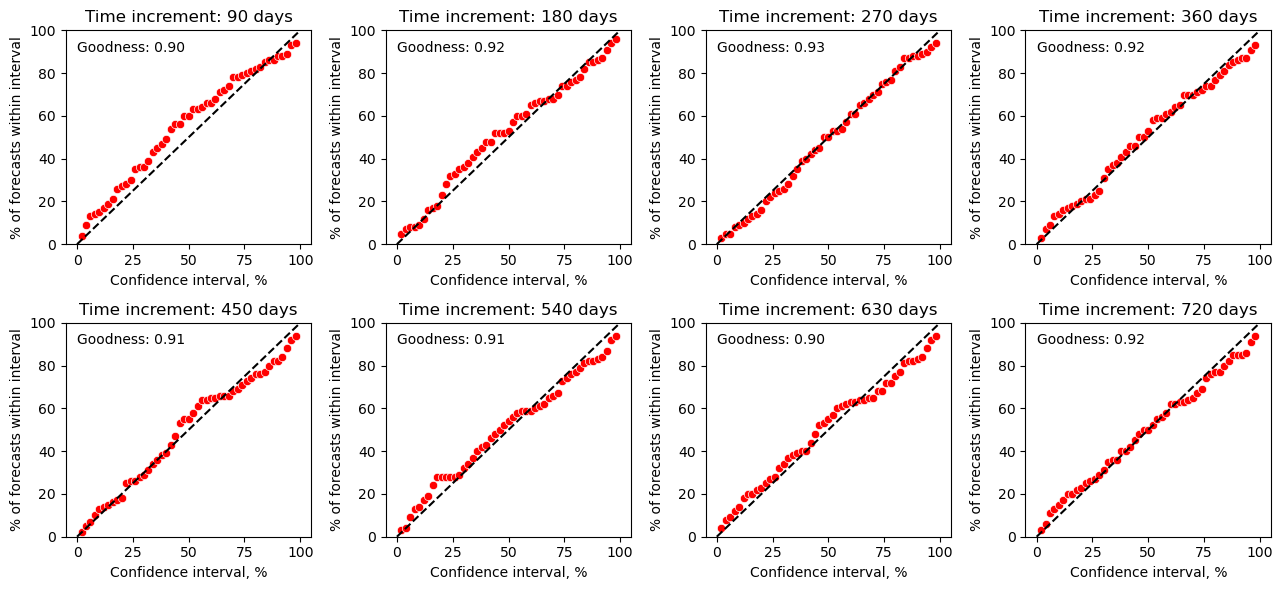

In [74]:
# reshape the score array to [time_increments, confidence_intervals, well_objects]
transposed_score_array_bs = np.transpose(score_array_bs, (2,1,0))

# convert the score arrays to a percentage score fore each confidence interval
# output array is [time_increments, pct_score_by_confidence_interval]
percentage_scores_bs = np.sum(np.transpose(score_array_bs, (2,1,0)), axis=2) / transposed_score_array.shape[2]

# plot summary scores for each time increment
confidence_intervals = forecast_parameters.well_objects.iloc[0].confidence_intervals

# create an empty array for the goodness scores
goodness_scores = dict()

fig, axs = plt.subplots(nrows=int((max_windows+1)/4), ncols=4, figsize=(golden_ratio * 2 * 4, 6))

for i in range(0, max_windows-1):
    
    x = np.array(confidence_intervals) * 2
    y = percentage_scores_bs[i, :]
    
    # create the scores
    ci_intervals = x / 100   
    indicator = (y >= ci_intervals).astype(int)
    goodness = 1 - (3 * indicator - 2) * (y - ci_intervals)
    piecewise = np.trapz(y=goodness, x=ci_intervals)
    
    window = (i+1) * time_increment
    goodness_scores[window] = piecewise
    
    sns.scatterplot(x=x, y=y*100, color='r', ax=axs[i//4,i%4])
    axs[i//4, i%4].plot((0,100), (0,100), 'k--')
    axs[i//4, i%4].set(title=f'Time increment: {window} days', xlabel='Confidence interval, %', 
               ylabel='% of forecasts within interval', ylim=(0,100))
    axs[i//4, i%4].text(0, 90, f'Goodness: {piecewise:.2f}')
    
plt.tight_layout(); plt.show()

# Test the concept on one of the study wells

In [3]:
# load the data into a df
prod = pd.read_csv(r'DAILY_PRODUCTION.csv')
prod['D_DATE'] = pd.to_datetime(prod['D_DATE'])
prod['ON'] = np.where(prod['OIL'] > 1, 1, 0)
prod['DAYS_ON'] = prod.groupby('WELL_NAME')['ON'].cumsum()
prod = prod[prod['ON'] > 0].copy()
prod['PCT_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1) * 100
prod['REL_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL']   
prod['REL_CHANGE_MOVING_AVG'] = prod['REL_CHANGE'].rolling(window=30, center=True).mean()
prod['PCT_CHANGE_MOVING_AVG'] = prod['PCT_CHANGE'].rolling(window=30, center=True).mean()

# filter any extreme values that will skew analytic plots further below
prod = prod[prod['PCT_CHANGE'] < 100000].copy()

In [11]:
well_a_history = prod.loc[prod['WELL_NAME'] == 'BUXBAUM 21-5-3H', 'OIL'].values

In [5]:
# instatntiate the same object with dummy information to have access to the functions.
well = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
beta = 0.5
loc = 0
scale = 0.05 
well.add_error(beta=beta, loc=loc, scale=scale)

In [12]:
# insert the well history into the object
well.rate_error = np.zeros(len(well.rate_error))
well.rate_error[:len(well_a_history)] = well_a_history

In [19]:
# apply bootstrap logic to the well data
bootstrap_iterations = 100
bootstrap_window = 30
time_increment = 90
max_windows = 9
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

well.windowed_bootstrap(iterations=bootstrap_iterations, window_size=bootstrap_window)
well.calc_forecasts(time_increments=time_increment, max_windows=max_windows, 
                    initial=initial_guess, bounds=bounds, which='bootstrap')

In [14]:
attributes = dir(well)
print(attributes)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calc_modified_arps', '_calculate_error_array', '_regress_forecast', 'add_error', 'average_forecast_error_quantiles', 'avg_fcst_error_quantiles', 'b', 'bootstrap', 'bootstrap_array', 'calc_forecasts', 'confidence_intervals', 'cum', 'cum_error', 'di', 'dmin', 'eur', 'eur_error', 'fcst_eur_array', 'monte_carlo', 'qab', 'qi', 'quantiles', 'rate', 'rate_error', 'rate_error_moving_avg', 'score_array', 'score_prediction', 't', 'time_scalar', 'time_scale', 'windowed_bootstrap']


In [87]:
# get the 5th percentile of the array
(np.percentile(well.fcst_eur_array, 95, axis=0) - np.percentile(well.fcst_eur_array, 5, axis=0))/2

array([80222.6466962 , 23301.026078  , 19889.36371095, 17444.90213646,
       16339.33230814, 15256.53681876, 14533.48272455, 14110.70487346,
       13230.82219012])

In [88]:
np.percentile(well.fcst_eur_array, 50, axis=0)

array([311360.00270946, 397397.78065876, 407224.83728767, 405259.05452113,
       406406.49389469, 406052.09827224, 405154.23935844, 405556.11376474,
       405026.88187401])

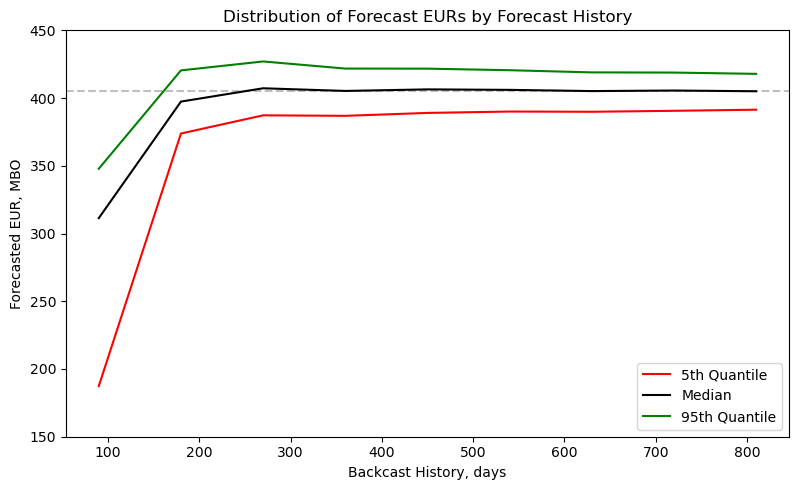

In [89]:
windows = range(time_increment, (time_increment + 1) * max_windows, time_increment)

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(405, c='gray', ls='--', alpha=0.5)
ax.plot(windows, np.percentile(well.fcst_eur_array, 5, axis=0)/1000, 'r-', label='5th Quantile')
ax.plot(windows, np.percentile(well.fcst_eur_array, 50, axis=0)/1000, 'k-', label='Median')
ax.plot(windows, np.percentile(well.fcst_eur_array, 95, axis=0)/1000, 'g-', label='95th Quantile')
ax.set(xlabel='Backcast History, days', ylabel='Forecasted EUR, MBO', 
       title='Distribution of Forecast EURs by Forecast History',
       ylim=(150, 450))
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()

In [54]:
def calculate_single_monte_carlo_fit(boot_strap_iteration, window_max, initial, bounds, which):
    history = well.bootstrap_array[boot_strap_iteration, :window_max]
    match_di, match_b = minimize(well._regress_forecast, 
                                 x0=initial, 
                                 args=(history), 
                                 bounds=bounds).x
    forecast = well._calc_modified_arps(qi=test.qi, di=match_di, b=match_b, dmin=test.dmin, qab=test.qab)
    return forecast, match_di, match_b

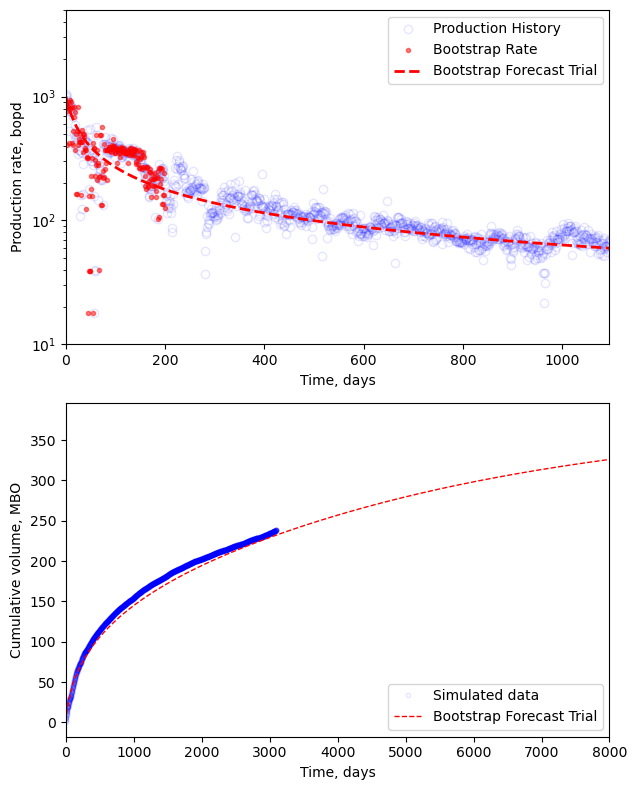

In [85]:
# plot the production rate and cumulative production with error for the test instance
moving_avg = pd.Series(well_a_history).rolling(window=30, min_periods=1).mean()
x = range(len(well_a_history))

# capture one of the bootstrap iterations and plot the forecast

bootstrap_index = np.random.randint(0, well.bootstrap_array.shape[0])
bootstrap_rate = well.bootstrap_array[bootstrap_index, :]
bootstrap_cum = np.cumsum(bootstrap_rate)

window_size = 200
bounds = [(0.5, 0.99), (0.5, 1.5)]
initial_guess = [0.75, 1.001]
which = 'bootstrap'
forecast, match_di, match_b = calculate_single_monte_carlo_fit(bootstrap_index, window_size, initial_guess, bounds, which)

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(golden_ratio * 4 , 4 * 2))
axs[0].plot(x, well_a_history, 'o', c='none', mec='b', alpha=0.10, label='Production History')
axs[0].plot(range(len(bootstrap_rate[:window_size])), bootstrap_rate[:window_size], '.', c='r', alpha=0.5, label='Bootstrap Rate')
axs[0].plot(range(len(forecast)), forecast, 'r--', label='Bootstrap Forecast Trial', lw=2)
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', xlim=(0,365 * 3), ylim=(10, 5000), yscale='log')
axs[0].legend(loc='upper right')
axs[1].plot(x, np.cumsum(well_a_history)/1000, '.', c='none', mec='b', alpha=0.10, label='Simulated data')
axs[1].plot(range(len(forecast)), np.cumsum(forecast)/1000, 'r--', label='Bootstrap Forecast Trial', lw=1)
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, MBO', xlim=(0,8000))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()